### (1) Fixing files

In [61]:
%matplotlib inline  
import csv
import matplotlib.pyplot as plt
import os

path = 'rozciaganie/klejone.is_tens_RawData/'

#--- find all datafiles
datafiles = [os.path.join(path,file) for file in os.listdir(path)]

#--- fix files
for file in datafiles:
    newfile = file.replace('Specimen','SpecimenClean')
    # change encoding, crop header & save
    !uconv --from-code ISO_8859-1 --to-code UTF8 $file | tail -n +5 >> $newfile 
    os.remove(file)

### (2) Loading data 

In [131]:
N_sample = 82

force_all = []
strch_all = []

for sample in range(1, N_sample+1):
    file = path + f'SpecimenClean_RawData_{str(sample)}.csv'
    
    #--- single file data
    force = []
    strch = []

    with open(file, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')    
        for row in reader:
            force.append(float(''.join([c for c in row[2] if c in '1234567890,']).replace(',','.')))
            strch.append(float(row[1].replace(',','.')))
    
    force_all.append(force)
    strch_all.append(strch)

#### (2.1) Saving correct files

In [169]:
for sample in range(1, N_sample+1):
    
    file = path + f'SpecimenClean_RawData_{str(sample)}.csv'
    newfile = path + f'Specimen_RawData_correct_{str(sample).zfill(2)}.csv'

    time = []
    force = []
    strch = []

    with open(file, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')    
        for row in reader:
            time.append(row[0])
            strch.append(row[1])
            force.append(''.join([c for c in row[2] if c in '1234567890,']))

    with open(newfile, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ')
        for tim, strc, forc in zip(time, strch, force):
            writer.writerow([tim]+[strc]+[forc])

### (3) Plotting...

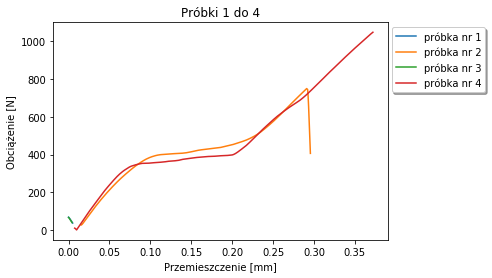

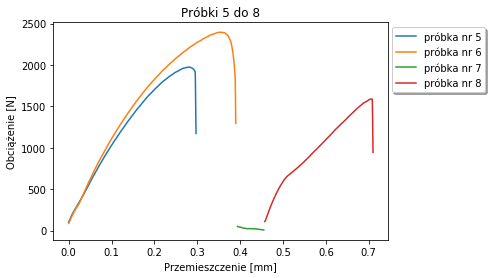

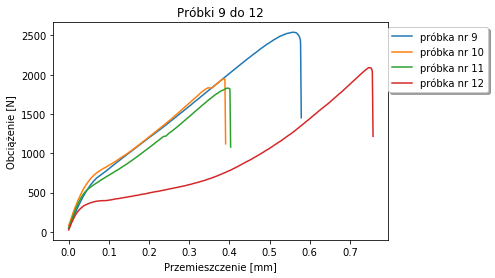

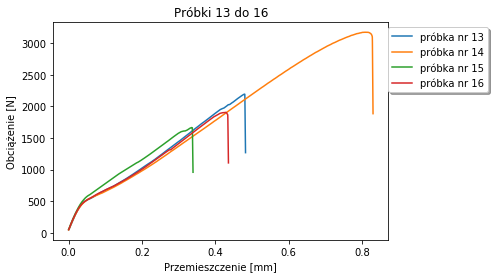

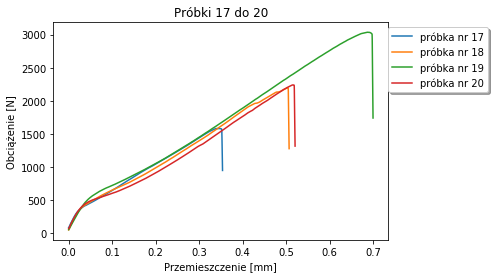

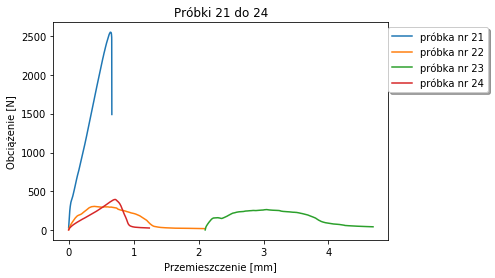

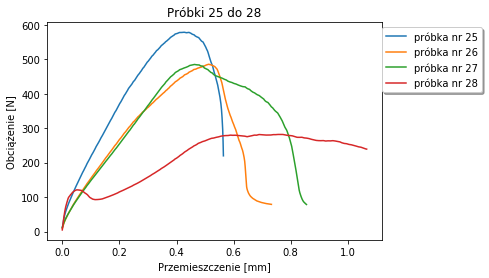

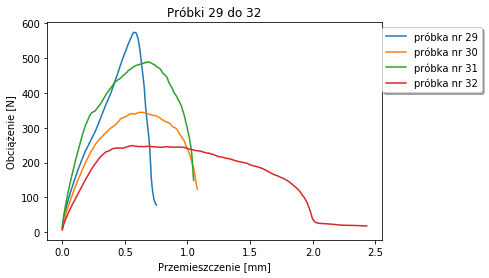

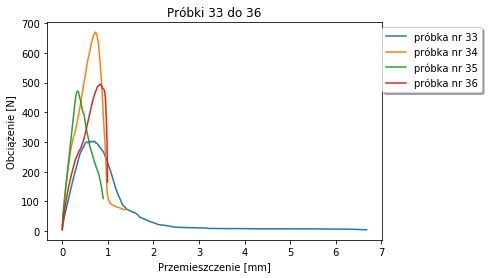

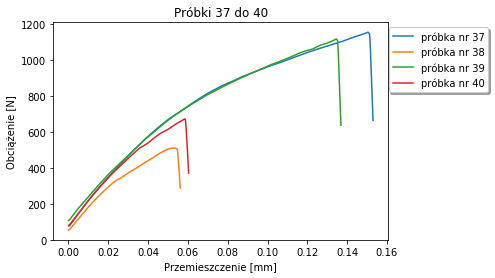

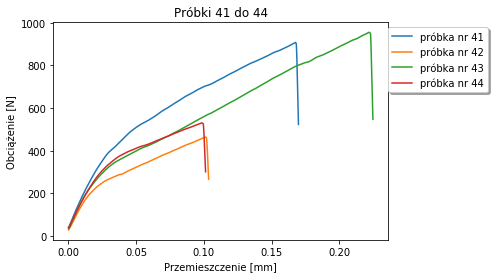

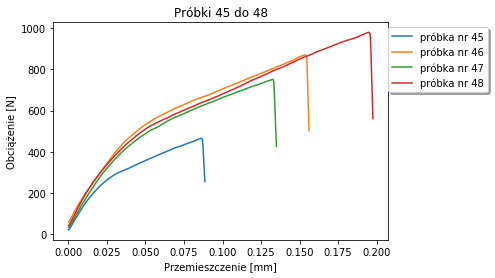

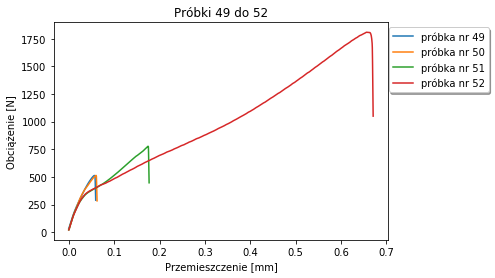

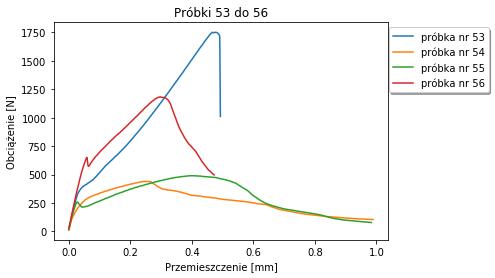

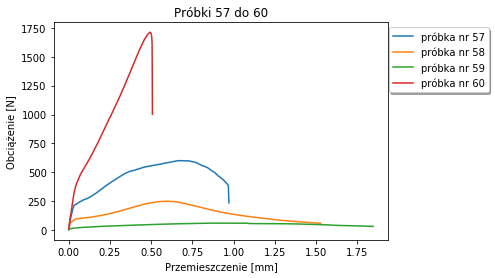

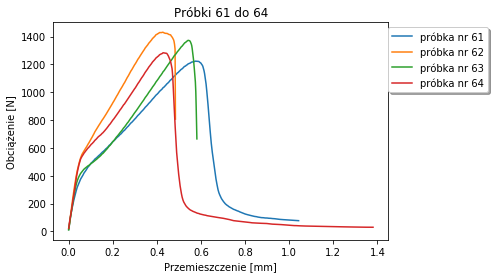

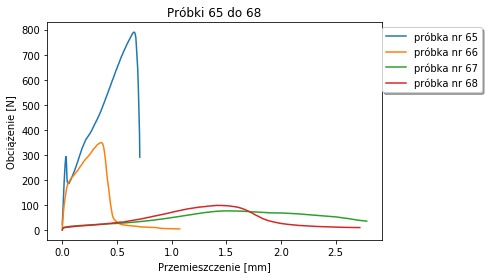

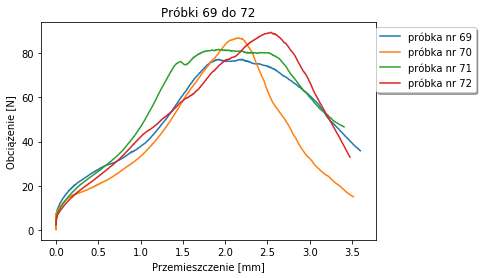

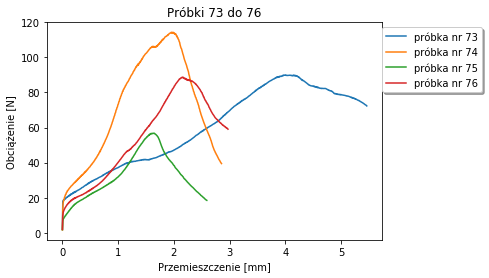

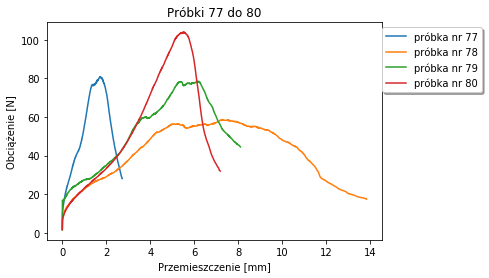

In [157]:
import math

#--- draw plots
for fig in range(math.ceil(N_sample/4)-1):
    plt.plot(strch_all[4*fig],  force_all[4*fig]  , strch_all[4*fig+1],force_all[4*fig+1],
             strch_all[4*fig+2],force_all[4*fig+2], strch_all[4*fig+3],force_all[4*fig+3])
    plt.xlabel('Przemieszczenie [mm]')
    plt.ylabel('Obciążenie [N]')
    plt.title(f'Próbki {str(4*fig+1)} do {str(4*fig+4)}')
    plt.legend([f'próbka nr {str(4*fig+x)}' for x in range(1,5)], loc='upper center', bbox_to_anchor=(1.15, 1),
              fancybox=True, shadow=True)
    plt.show()

In [160]:
force

[2.98382,
 5.50189,
 8.21537,
 10.77672,
 13.39516,
 15.90859,
 16.14101,
 16.27937,
 17.16095,
 17.29618,
 18.1502,
 17.9633,
 18.67954,
 18.78078,
 19.39946,
 19.23516,
 19.81259,
 19.69364,
 20.24811,
 20.04158,
 20.49028,
 20.31243,
 20.9052,
 20.63965,
 20.99687,
 20.89245,
 21.27062,
 21.11045,
 21.4933,
 21.35274,
 21.77878,
 21.67989,
 21.8779,
 21.85809,
 22.03201,
 22.23232,
 22.33425,
 22.46524,
 22.64582,
 22.74499,
 22.79739,
 23.07522,
 23.09745,
 23.37356,
 23.41636,
 23.61563,
 23.76377,
 23.85536,
 23.91462,
 24.13743,
 24.25768,
 24.55982,
 24.48277,
 24.75882,
 24.69207,
 25.01727,
 24.8531,
 25.23676,
 25.13318,
 25.58071,
 25.38354,
 25.75017,
 25.57856,
 26.00632,
 25.92678,
 26.217,
 26.16948,
 26.47569,
 26.46175,
 26.73324,
 26.63325,
 26.90724,
 26.96256,
 27.20692,
 27.24988,
 27.41245,
 27.51854,
 27.69326,
 27.76931,
 27.93058,
 28.07229,
 28.24602,
 28.45068,
 28.51357,
 28.74538,
 28.72025,
 29.00417,
 29.07186,
 29.28744,
 29.29321,
 29.62747,
 29.62018,